# Competition "Don't Overfit"

- **data**: https://www.kaggle.com/c/overfitting
- **data description**:  \
    **trainset**에는 **250**개의 row, **testset**에는 **19750**개의 row가 존재한다.  
    우리는 이 데이터를 trainset에 overfitting 시키지 않은 채로 잘 학습을 시켜야 한다! \
    해당 데이터셋에 연습용 target label이 존재하므로 250개를 trainset, 나머지를 testset으로 나누어 진행해보자

## 1. Import Modules and Load Data

In [1]:
# data
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LassoCV, RidgeCV
from xgboost import XGBClassifier

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, make_scorer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline

In [2]:
df = pd.read_csv("overfitting.csv")
df.drop(['case_id', 'train', 'Target_Leaderboard', 'Target_Evaluate'], axis=1, inplace=True)

train = df.iloc[:250, :]
test = df.iloc[250:, :]

In [3]:
display(train.head())

,Target_Practice,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_200
0,0,0.660,0.106,0.434,0.387,0.903,0.661,0.158,0.291,0.210,...,0.015,0.377,0.479,0.050,0.395,0.123,0.833,0.461,0.990,0.105
1,1,0.844,0.813,0.030,0.939,0.721,0.287,0.539,0.874,0.787,...,0.112,0.048,0.088,0.860,0.560,0.346,0.511,0.883,0.858,0.599
2,0,0.560,0.567,0.568,0.434,0.414,0.180,0.448,0.888,0.023,...,0.874,0.236,0.599,0.602,0.005,0.493,0.122,0.395,0.782,0.943
3,0,0.681,0.245,0.909,0.785,0.738,0.570,0.692,0.411,0.182,...,0.219,0.691,0.261,0.031,0.968,0.353,0.798,0.104,0.944,0.090
4,0,0.846,0.431,0.805,0.237,0.465,0.642,0.219,0.102,0.795,...,0.704,0.242,0.089,0.605,0.577,0.043,0.686,0.070,0.666,0.572


In [4]:
# 250개의 trainset, 19750개의 testset 완성
train.shape, test.shape

((250, 201), (19750, 201))

## 2. EDA

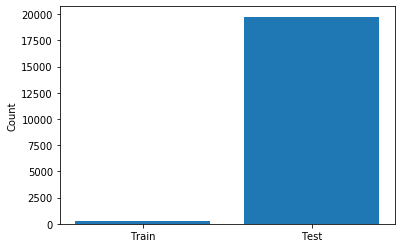

In [5]:
plt.bar(range(2), (train.shape[0], test.shape[0])) 
plt.xticks(range(2), ('Train', 'Test'))
plt.ylabel('Count') 
plt.show()

- Train의 크기가 Test에 비해 매우 작은 것을 알 수 있다.

In [6]:
train.isnull().any().any()

False

In [7]:
test.isnull().any().any()

False

- Null은 다행히도 존재하지 않는다!

In [8]:
train['Target_Practice'].value_counts()

1    131
0    119
Name: Target_Practice, dtype: int64

- target의 종류가 고르게 분포되어있는 balanced data임을 알 수 있다.

## 3. Preprocessing

In [9]:
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

- train과 test data의 target을 분리해주었다.

In [10]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [11]:
rc = RobustScaler()
X_train_rc = rc.fit_transform(X_train)
X_test_rc = rc.transform(X_test)

## 4. Modeling

- Model은 최대한 단순한 것을 사용하여 overfitting을 줄이자!

In [13]:
# Overfitting을 방지하기 위해 작은 Noise를 부여
X_train_n = X_train + np.random.normal(0, 0.01, X_train.shape)
X_train_sc_n = X_train_sc + np.random.normal(0, 0.01, X_train.shape)
X_train_rc_n = X_train_rc + np.random.normal(0, 0.01, X_train.shape)

### With No Pipeline

In [14]:
# Validation function
n_folds = 10

def roc_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    roc = cross_val_score(model, train.values, y_train, scoring='roc_auc', cv = kf)
    return(roc)

In [39]:
# Model & Parameters
param_lasso = {
            'alpha' : [0.019, 0.021, 0.023, 0.025, 0.027, 0.029, 0.031, 0.033],
            'tol'   : [0.001, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016, 0.0017],
}

param_logistic = {
            'C' : [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2],
            'penalty' : ['l1', 'l2']
}

lasso = Lasso(alpha=0.031, tol=0.01, random_state=42, selection='random')
lr = LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')

In [40]:
def print_best_params(model, params):
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        cv=5,
        scoring='roc_auc')

    grid_model.fit(X_train, y_train)
    print('{0} Best Average ROC: {1} \nBest Parameters: {2}'.format(model.__class__.__name__, np.round(grid_model.best_score_, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [41]:
lasso_estimator = print_best_params(lasso, param_lasso)

Lasso Best Average ROC: 0.6527 
Best Parameters: {'alpha': 0.019, 'tol': 0.001}


In [42]:
logistic_estimator = print_best_params(lr, param_logistic)

LogisticRegression Best Average ROC: 0.6585 
Best Parameters: {'C': 0.2, 'penalty': 'l2'}


In [43]:
lasso = Lasso(alpha=0.019, tol=0.001, random_state=42, selection='random')
lr = LogisticRegression(class_weight='balanced', penalty='l2', C=0.2, solver='liblinear')

### With Pipeline

In [25]:
pipe = Pipeline(steps=[
    ('pre', None),
    ('feature_selection', None),
    ('clf', LogisticRegression(solver='liblinear')),
    ]
)

params = {  
    'pre': [
        None, StandardScaler(), RobustScaler(),
    ],
    'feature_selection': [
        None, 
        SelectFromModel(LogisticRegression(solver='liblinear')),
        SelectFromModel(XGBClassifier(n_estimators=500, max_depth=2)),
    ],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2] ,
    'clf__class_weight': [None, 'balanced']
}

In [26]:
# Noise 추가 안함
clf = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=10, n_jobs=-1)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pre', None), ('feature_selection', None), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'pre': [None, StandardScaler(copy=True, with_mean=True, with_std=True), RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)], 'feature_selection': [None, SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit... 'l2'], 'clf__C': [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2], 'clf__class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [27]:
clf.best_estimator_

Pipeline(memory=None,
     steps=[('pre', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', None), ('clf', LogisticRegression(C=0.2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [30]:
clf.best_score_

0.8515990675990676

In [28]:
# Noise 추가
clf2 = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=10, n_jobs=-1)
clf2.fit(X_train_n, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pre', None), ('feature_selection', None), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'pre': [None, StandardScaler(copy=True, with_mean=True, with_std=True), RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)], 'feature_selection': [None, SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit... 'l2'], 'clf__C': [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2], 'clf__class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [29]:
clf2.best_estimator_

Pipeline(memory=None,
     steps=[('pre', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', None), ('clf', LogisticRegression(C=0.2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [31]:
clf2.best_score_

0.8477665667665668

- StandardScaler를 적용한 Logistic Regression이 성능이 더 좋았다.
- 확실히 XGB와 같은 복잡하고 무거운 모델보다는 단순한 Logistic Regression이 더 좋은 성능을 보이고 있다.
- best estimator로 tuning한 Logistic Regression을 다른 모델과도 비교해보자!

In [32]:
pipe_2 = Pipeline(steps=[
    ('pre', None),
    ('feature_selection', None),
    ('clf', Lasso(selection='random')),
    ]
)

params_2 = {  
    'pre': [
        None, StandardScaler(), RobustScaler(),
    ],
    'feature_selection': [
        None,
        SelectFromModel(Lasso(alpha=0.031, tol=0.01, random_state=42, selection='random')),
        SelectFromModel(LogisticRegression(C=0.2, penalty='l2', class_weight ='balanced', solver='liblinear')),
    ],
    'clf__alpha': [0.019, 0.021, 0.023, 0.025, 0.027, 0.029, 0.031, 0.033],
    'clf__tol' : [0.001, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016, 0.0017]
}


In [33]:
# Noise 추가 안함
clf3 = GridSearchCV(pipe_2, param_grid=params_2, scoring='roc_auc', cv=10, n_jobs=-1)
clf3.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pre', None), ('feature_selection', None), ('clf', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='random', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'pre': [None, StandardScaler(copy=True, with_mean=True, with_std=True), RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)], 'feature_selection': [None, SelectFromModel(estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter..., 0.029, 0.031, 0.033], 'clf__tol': [0.001, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [34]:
clf3.best_estimator_

Pipeline(memory=None,
     steps=[('pre', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', None), ('clf', Lasso(alpha=0.019, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='random', tol=0.0014, warm_start=False))])

In [35]:
clf3.best_score_

0.7711769619269621

In [36]:
# Noise 추가
clf4 = GridSearchCV(pipe_2, param_grid=params_2, scoring='roc_auc', cv=10, n_jobs=-1)
clf4.fit(X_train_n, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pre', None), ('feature_selection', None), ('clf', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='random', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'pre': [None, StandardScaler(copy=True, with_mean=True, with_std=True), RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)], 'feature_selection': [None, SelectFromModel(estimator=Lasso(alpha=0.031, copy_X=True, fit_intercept=True, max_iter..., 0.029, 0.031, 0.033], 'clf__tol': [0.001, 0.0011, 0.0012, 0.0013, 0.0014, 0.0015, 0.0016, 0.0017]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [37]:
clf4.best_estimator_

Pipeline(memory=None,
     steps=[('pre', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', None), ('clf', Lasso(alpha=0.019, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='random', tol=0.0013, warm_start=False))])

In [38]:
clf4.best_score_

0.7779583472083471

- StandardScaler를 적용한 Lasso의 성능이 가장 좋게 나왔다!
- 마지막으로 Logistic과 Lasso를 다시 Tuning해서 결과를 비교해보자

In [44]:
param_logistic = {
            'C' : [0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.3],
}

param_lasso = {
            'alpha' : [0.015, 0.016, 0.017, 0.018, 0.019, 0.02],
            'tol'   : [0.0012, 0.0013, 0.0014, 0.0015, 0.0016, 0.0017],
}

In [45]:
logistic_estimator_final = print_best_params(lr, param_logistic)

LogisticRegression Best Average ROC: 0.6591 
Best Parameters: {'C': 0.3}


In [46]:
lr_final = LogisticRegression(class_weight='balanced', penalty='l2', C=0.3, solver='liblinear')

In [47]:
lasso_estimator_final = print_best_params(lasso, param_lasso)

Lasso Best Average ROC: 0.6707 
Best Parameters: {'alpha': 0.015, 'tol': 0.0012}


In [48]:
lasso_final = Lasso(alpha=0.015, tol=0.0012, random_state=42, selection='random')

## 5. Evaluation

### With No Pipeline

- Noise 추가 안함

In [49]:
lasso.fit(X_train_sc, y_train)
y_pred_la_s = lasso.predict(X_test_sc)
print("ROC AUC SCORE : ", roc_auc_score(y_test, y_pred_la_s))

ROC AUC SCORE :  0.8129616334166779


In [50]:
lasso.fit(X_train_rc, y_train)
y_pred_la_r = lasso.predict(X_test_rc)
print("ROC AUC SCORE : ", roc_auc_score(y_test, y_pred_la_r))

ROC AUC SCORE :  0.772416399047407


In [51]:
lr.fit(X_train_sc, y_train)
y_pred_lr_s = lasso.predict(X_test_sc)
print("ROC AUC SCORE : ", roc_auc_score(y_test, y_pred_lr_s))

ROC AUC SCORE :  0.7731657442548345


In [52]:
lr.fit(X_train_rc, y_train)
y_pred_lr_r = lasso.predict(X_test_rc)
print("ROC AUC SCORE : ", roc_auc_score(y_test, y_pred_lr_r))

ROC AUC SCORE :  0.772416399047407


- Noise 추가

In [53]:
lasso.fit(X_train_sc_n, y_train)
y_pred_la_s = lasso.predict(X_test_sc)
print("ROC AUC SCORE : ", roc_auc_score(y_test, y_pred_la_s))

ROC AUC SCORE :  0.8124527448331795


In [54]:
lasso.fit(X_train_rc_n, y_train)
y_pred_la_r = lasso.predict(X_test_rc)
print("ROC AUC SCORE : ", roc_auc_score(y_test, y_pred_la_r))

ROC AUC SCORE :  0.7729726652154564


In [55]:
lr.fit(X_train_sc_n, y_train)
y_pred_lr_s = lasso.predict(X_test_sc)
print("ROC AUC SCORE : ", roc_auc_score(y_test, y_pred_lr_s))

ROC AUC SCORE :  0.7736928557750747


In [56]:
lr.fit(X_train_rc_n, y_train)
y_pred_lr_s = lasso.predict(X_test_sc)
print("ROC AUC SCORE : ", roc_auc_score(y_test, y_pred_lr_s))

ROC AUC SCORE :  0.7736928557750747


### With Pipeline

In [62]:
print("ROC AUC SCORE : ", roc_auc_score(y_test, clf3.predict(X_test_sc)))

ROC AUC SCORE :  0.8130472822448533


In [63]:
print("ROC AUC SCORE : ", roc_auc_score(y_test, clf4.predict(X_test_sc)))

ROC AUC SCORE :  0.8109074151857403


In [65]:
lasso_final.fit(X_train_sc, y_train)
y_pred = lasso_final.predict(X_test_sc)
print("ROC AUC SCORE : ", roc_auc_score(y_test, y_pred))

ROC AUC SCORE :  0.8264665215989639


In [67]:
lr_final.fit(X_train_sc, y_train)
y_pred = lr_final.predict(X_test_sc)
print("ROC AUC SCORE : ", roc_auc_score(y_test, y_pred))

ROC AUC SCORE :  0.7786643590296329


- 최종 Model은 **"Lasso Final"**로 채택되었다!
- 가장 높은 ROC AUC Score는 **0.8264665215989639**이 나왔다.
- **Pipeline**은 모든 과정을 하나로 압축하여 진행하므로, input output 순서만 잘 고려한다면 유용한 방법이 될 것 같다!